# Federated Learning on Fashion MNIST using CNN
*Author: Yasir Abdur Rohman*
<hr>

# Introduction
In this project, we will implement federated learning on Fashion MNIST dataset using CNN. Federated Learning is a machine learning setting where the goal is to train a high-quality centralized model with training data distributed over a large number of clients each with unreliable and relatively slow network connections. This project inspired by an example from Pysyft tutorial on [Federated CIFAR10](https://github.com/OpenMined/PySyft/blob/dev/examples/tutorials/advanced/Federated%20CIFAR10.ipynb).

For the better model performance, we will use transfer learning from a pre-trained model.

The project consists of the following steps:
1. Import and model Specification
2. Load data
3. Convolutional Neural Network
4. Training

# Step 1: Import and model specification

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, models, transforms

# pysyft
import syft as sy

import numpy as np
import matplotlib.pyplot as plt

W0821 06:06:49.046733 22572 secure_random.py:26] Falling back to insecure randomness since the required custom op could not be found for the installed version of TensorFlow. Fix this by compiling custom ops. Missing file was 'D:\Anaconda3\envs\pysyft\lib\site-packages\tf_encrypted/operations/secure_random/secure_random_module_tf_1.14.0.so'
W0821 06:06:49.058670 22572 deprecation_wrapper.py:119] From D:\Anaconda3\envs\pysyft\lib\site-packages\tf_encrypted\session.py:26: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



## Setting hyperparameters

In [2]:
class Arguments():
    def __init__(self):
        self.batch_size = 64
        self.test_batch_size = 1000
        self.epochs = 25
        self.lr = 0.001
        self.momentum = 0.5
        self.no_cuda = True
        self.seed = 1
        self.log_interval = 30
        self.save_model = False

args = Arguments()

use_cuda = not args.no_cuda and torch.cuda.is_available()

torch.manual_seed(args.seed)

device = torch.device("cuda" if use_cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

## Initialize workers

In [3]:
hook = sy.TorchHook(torch)
bob = sy.VirtualWorker(hook, id="bob")
alice = sy.VirtualWorker(hook, id="alice")

# Step 2: Load Data

In [8]:
def load_data():
    
    '''Load Fashion MNIST dataset from torch vision module distribute to workers using PySyft's Federated Data loader'''
    

    federated_train_loader = sy.FederatedDataLoader(
        datasets.FashionMNIST('../data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.5,), (0.5,))
                       ]))
        .federate((bob, alice)),
        batch_size=args.batch_size, shuffle=True, **kwargs)

    test_loader = torch.utils.data.DataLoader(
        datasets.FashionMNIST('../data', train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.5,), (0.5,))
                       ])),
        batch_size=args.test_batch_size, shuffle=True, **kwargs)

    return federated_train_loader,test_loader

In [9]:
federated_train_loader, test_loader = load_data()

## Visualize some dataset

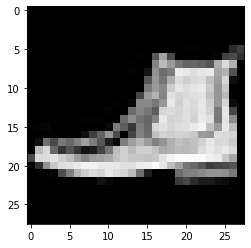

In [10]:
# obtain one batch of training images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

plt.imshow(images[1].squeeze(), cmap='Greys_r')

# Step 3: Convolutional Neural Network
**Note:** Since <code>BatchNorm</code> is still not compatible in Federated Learning as issued in [#2132](https://github.com/OpenMined/PySyft/issues/2132), we cannot using transfer learning from pre-trained model such as Resnet18, VGG16. So for the solution we will make CNN layer manually as follows.

In [11]:
# download resnet 18 model
# resnet18 = models.resnet18(pretrained=True)

# Freeze training for all "features" layers
# for param in resnet18.parameters():
#     param.requires_grad = False
    
# num_ftrs = resnet18.fc.in_features

# resnet18.fc = nn.Sequential(nn.Linear(num_ftrs, 256),
#                             nn.Dropout(0.3),
#                             nn.Linear(256, 128),
#                             nn.Dropout(0.3),
#                             nn.Linear(128, 64),
#                             nn.Dropout(0.3),
#                             nn.Linear(64, 10),
#                             nn.LogSoftmax(dim=1))
# architecture resnet18 modified
# resnet18

In [12]:
class CNN(nn.Module):
    def __init__(self,num_classes=10):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

## Train Function

In [13]:
def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(federated_train_loader):
        model.send(data.location)
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        model.get()
        if batch_idx % args.log_interval == 0:
            loss = loss.get()
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * args.batch_size, len(train_loader) * args.batch_size, #batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

## Test Function

In [14]:
def test(args, model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(1, keepdim=True) # get the index of the max log-probability 
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

# Step 4: Training Neural Network

In [15]:
# resnet18 = resnet18.to(device)
cnn = CNN().to(device)
optimizer = optim.Adam(cnn.parameters(), lr=args.lr)

# Train Neural network and validate with test set after completion of training every epoch
for epoch in range(1, args.epochs + 1):
    train(args, cnn, device, federated_train_loader, optimizer, epoch)
    test(args, cnn, device, test_loader)

if (args.save_model):
    torch.save(cnn.state_dict(), "FashionMNIST_cnn.pt")

Train Epoch: 1 [0/60032 (0%)]	Loss: 2.305633
Train Epoch: 1 [1920/60032 (3%)]	Loss: 0.740293
Train Epoch: 1 [3840/60032 (6%)]	Loss: 0.725667
Train Epoch: 1 [5760/60032 (10%)]	Loss: 0.552224
Train Epoch: 1 [7680/60032 (13%)]	Loss: 0.808906
Train Epoch: 1 [9600/60032 (16%)]	Loss: 0.540031
Train Epoch: 1 [11520/60032 (19%)]	Loss: 0.476487
Train Epoch: 1 [13440/60032 (22%)]	Loss: 0.433211
Train Epoch: 1 [15360/60032 (26%)]	Loss: 0.367201
Train Epoch: 1 [17280/60032 (29%)]	Loss: 0.437580
Train Epoch: 1 [19200/60032 (32%)]	Loss: 0.465955
Train Epoch: 1 [21120/60032 (35%)]	Loss: 0.478523
Train Epoch: 1 [23040/60032 (38%)]	Loss: 0.569970
Train Epoch: 1 [24960/60032 (42%)]	Loss: 0.323152
Train Epoch: 1 [26880/60032 (45%)]	Loss: 0.535027
Train Epoch: 1 [28800/60032 (48%)]	Loss: 0.366544


TypeError: add_() takes 1 positional argument but 2 were given

## My Notes
For some reason, when the model is training suddenly stopped at 48%. I don't know if this is a bug or my code has an error. But, so far we already implementing Federated Learning on Fashion MNIST using CNN. For the future, I hope we can doing transfer learning on Federated Learning.